In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "QPM_species"
model_name = "flow_mse"
ood = "1"

In [3]:
# Parameters
ood = 2


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 274157 images
Dataset type val label type: species


Loaded 35900 images
Dataset type test label type: species


Loaded 36128 images
Dataset type train label type: species


Loaded 101286 images
Dataset type val label type: species


Loaded 12662 images
Dataset type test label type: species


Loaded 12662 images


In [6]:
# model id for each ood_k
model_ids = ['3qdutcy1', 'czgx4bod', '72y7x1fk', 'cqp59iho', 'fwur6c78']
model_id = model_ids[config.ood[0]]
print(model_id)

72y7x1fk


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

ind_targets = []
ood_targets = []

ind_u_norms = []
ood_u_norms = []
rnd_u_norms = []

ind_v_norms = []
ood_v_norms = []
rnd_v_norms = []

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
for batch_idx, batch in enumerate(tqdm(predict_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ood_u_norms.extend(u_norm.detach().cpu().numpy())
    ood_v_norms.extend(v_norm.detach().cpu().numpy())
    ood_targets.extend(y.detach().cpu().numpy())
print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

ind_targets = np.array(ind_targets).squeeze()
ood_targets = np.array(ood_targets).squeeze()
    
ind_u_norms = np.array(ind_u_norms).squeeze()
ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

ind_v_norms = np.array(ind_v_norms).squeeze()
ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(ind_u_norms.shape, ind_v_norms.shape)
print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                                                                                  | 0/283 [00:00<?, ?it/s]

  0%|▌                                                                                                                                                         | 1/283 [00:01<05:37,  1.20s/it]

  1%|█                                                                                                                                                         | 2/283 [00:01<02:38,  1.77it/s]

  1%|██▏                                                                                                                                                       | 4/283 [00:01<01:14,  3.75it/s]

  2%|███▎                                                                                                                                                      | 6/283 [00:01<00:50,  5.47it/s]

  3%|████▎                                                                                                                                                     | 8/283 [00:01<00:39,  6.90it/s]

  4%|█████▍                                                                                                                                                   | 10/283 [00:02<00:33,  8.03it/s]

  4%|██████▍                                                                                                                                                  | 12/283 [00:02<00:30,  8.90it/s]

  5%|███████▌                                                                                                                                                 | 14/283 [00:02<00:28,  9.56it/s]

  6%|████████▋                                                                                                                                                | 16/283 [00:02<00:26, 10.04it/s]

  6%|█████████▋                                                                                                                                               | 18/283 [00:02<00:25, 10.39it/s]

  7%|██████████▊                                                                                                                                              | 20/283 [00:02<00:24, 10.63it/s]

  8%|███████████▉                                                                                                                                             | 22/283 [00:03<00:24, 10.80it/s]

  8%|████████████▉                                                                                                                                            | 24/283 [00:03<00:23, 10.93it/s]

  9%|██████████████                                                                                                                                           | 26/283 [00:03<00:23, 11.02it/s]

 10%|███████████████▏                                                                                                                                         | 28/283 [00:03<00:23, 11.08it/s]

 11%|████████████████▏                                                                                                                                        | 30/283 [00:03<00:22, 11.12it/s]

 11%|█████████████████▎                                                                                                                                       | 32/283 [00:03<00:22, 11.16it/s]

 12%|██████████████████▍                                                                                                                                      | 34/283 [00:04<00:22, 11.18it/s]

 13%|███████████████████▍                                                                                                                                     | 36/283 [00:04<00:22, 11.19it/s]

 13%|████████████████████▌                                                                                                                                    | 38/283 [00:04<00:21, 11.20it/s]

 14%|█████████████████████▋                                                                                                                                   | 40/283 [00:04<00:21, 11.20it/s]

 15%|██████████████████████▋                                                                                                                                  | 42/283 [00:04<00:21, 11.21it/s]

 16%|███████████████████████▊                                                                                                                                 | 44/283 [00:05<00:21, 11.21it/s]

 16%|████████████████████████▊                                                                                                                                | 46/283 [00:05<00:21, 11.21it/s]

 17%|█████████████████████████▉                                                                                                                               | 48/283 [00:05<00:20, 11.21it/s]

 18%|███████████████████████████                                                                                                                              | 50/283 [00:05<00:20, 11.22it/s]

 18%|████████████████████████████                                                                                                                             | 52/283 [00:05<00:20, 11.22it/s]

 19%|█████████████████████████████▏                                                                                                                           | 54/283 [00:05<00:20, 11.22it/s]

 20%|██████████████████████████████▎                                                                                                                          | 56/283 [00:06<00:20, 11.22it/s]

 20%|███████████████████████████████▎                                                                                                                         | 58/283 [00:06<00:20, 11.22it/s]

 21%|████████████████████████████████▍                                                                                                                        | 60/283 [00:06<00:19, 11.22it/s]

 22%|█████████████████████████████████▌                                                                                                                       | 62/283 [00:06<00:19, 11.23it/s]

 23%|██████████████████████████████████▌                                                                                                                      | 64/283 [00:06<00:19, 11.22it/s]

 23%|███████████████████████████████████▋                                                                                                                     | 66/283 [00:07<00:19, 11.23it/s]

 24%|████████████████████████████████████▊                                                                                                                    | 68/283 [00:07<00:19, 11.22it/s]

 25%|█████████████████████████████████████▊                                                                                                                   | 70/283 [00:07<00:18, 11.23it/s]

 25%|██████████████████████████████████████▉                                                                                                                  | 72/283 [00:07<00:18, 11.22it/s]

 26%|████████████████████████████████████████                                                                                                                 | 74/283 [00:07<00:18, 11.21it/s]

 27%|█████████████████████████████████████████                                                                                                                | 76/283 [00:07<00:18, 11.21it/s]

 28%|██████████████████████████████████████████▏                                                                                                              | 78/283 [00:08<00:18, 11.21it/s]

 28%|███████████████████████████████████████████▎                                                                                                             | 80/283 [00:08<00:18, 11.21it/s]

 29%|████████████████████████████████████████████▎                                                                                                            | 82/283 [00:08<00:17, 11.21it/s]

 30%|█████████████████████████████████████████████▍                                                                                                           | 84/283 [00:08<00:17, 11.21it/s]

 30%|██████████████████████████████████████████████▍                                                                                                          | 86/283 [00:08<00:17, 11.21it/s]

 31%|███████████████████████████████████████████████▌                                                                                                         | 88/283 [00:08<00:17, 11.21it/s]

 32%|████████████████████████████████████████████████▋                                                                                                        | 90/283 [00:09<00:17, 11.21it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                       | 92/283 [00:09<00:17, 11.20it/s]

 33%|██████████████████████████████████████████████████▊                                                                                                      | 94/283 [00:09<00:16, 11.20it/s]

 34%|███████████████████████████████████████████████████▉                                                                                                     | 96/283 [00:09<00:16, 11.20it/s]

 35%|████████████████████████████████████████████████████▉                                                                                                    | 98/283 [00:09<00:16, 11.21it/s]

 35%|█████████████████████████████████████████████████████▋                                                                                                  | 100/283 [00:10<00:16, 11.20it/s]

 36%|██████████████████████████████████████████████████████▊                                                                                                 | 102/283 [00:10<00:16, 11.21it/s]

 37%|███████████████████████████████████████████████████████▊                                                                                                | 104/283 [00:10<00:15, 11.21it/s]

 37%|████████████████████████████████████████████████████████▉                                                                                               | 106/283 [00:10<00:15, 11.21it/s]

 38%|██████████████████████████████████████████████████████████                                                                                              | 108/283 [00:10<00:15, 11.21it/s]

 39%|███████████████████████████████████████████████████████████                                                                                             | 110/283 [00:10<00:15, 11.21it/s]

 40%|████████████████████████████████████████████████████████████▏                                                                                           | 112/283 [00:11<00:15, 11.21it/s]

 40%|█████████████████████████████████████████████████████████████▏                                                                                          | 114/283 [00:11<00:15, 11.22it/s]

 41%|██████████████████████████████████████████████████████████████▎                                                                                         | 116/283 [00:11<00:14, 11.22it/s]

 42%|███████████████████████████████████████████████████████████████▍                                                                                        | 118/283 [00:11<00:14, 11.22it/s]

 42%|████████████████████████████████████████████████████████████████▍                                                                                       | 120/283 [00:11<00:14, 11.21it/s]

 43%|█████████████████████████████████████████████████████████████████▌                                                                                      | 122/283 [00:12<00:14, 11.21it/s]

 44%|██████████████████████████████████████████████████████████████████▌                                                                                     | 124/283 [00:12<00:14, 11.21it/s]

 45%|███████████████████████████████████████████████████████████████████▋                                                                                    | 126/283 [00:12<00:14, 11.21it/s]

 45%|████████████████████████████████████████████████████████████████████▋                                                                                   | 128/283 [00:12<00:13, 11.21it/s]

 46%|█████████████████████████████████████████████████████████████████████▊                                                                                  | 130/283 [00:12<00:13, 11.22it/s]

 47%|██████████████████████████████████████████████████████████████████████▉                                                                                 | 132/283 [00:12<00:13, 11.21it/s]

 47%|███████████████████████████████████████████████████████████████████████▉                                                                                | 134/283 [00:13<00:13, 11.22it/s]

 48%|█████████████████████████████████████████████████████████████████████████                                                                               | 136/283 [00:13<00:13, 11.21it/s]

 49%|██████████████████████████████████████████████████████████████████████████                                                                              | 138/283 [00:13<00:12, 11.22it/s]

 49%|███████████████████████████████████████████████████████████████████████████▏                                                                            | 140/283 [00:13<00:12, 11.21it/s]

 50%|████████████████████████████████████████████████████████████████████████████▎                                                                           | 142/283 [00:13<00:12, 11.18it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▎                                                                          | 144/283 [00:13<00:12, 11.19it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▍                                                                         | 146/283 [00:14<00:12, 11.20it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▍                                                                        | 148/283 [00:14<00:12, 11.19it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                       | 150/283 [00:14<00:11, 11.20it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                      | 152/283 [00:14<00:11, 11.19it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▋                                                                     | 154/283 [00:14<00:11, 11.19it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▊                                                                    | 156/283 [00:15<00:11, 11.20it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 158/283 [00:15<00:11, 11.20it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 160/283 [00:15<00:10, 11.20it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████                                                                 | 162/283 [00:15<00:10, 11.18it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████                                                                | 164/283 [00:15<00:10, 11.18it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 166/283 [00:15<00:10, 11.19it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 168/283 [00:16<00:10, 11.17it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 170/283 [00:16<00:10, 11.16it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 172/283 [00:16<00:09, 11.17it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 174/283 [00:16<00:09, 11.16it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 176/283 [00:16<00:09, 11.16it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 178/283 [00:17<00:09, 11.17it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 180/283 [00:17<00:09, 11.17it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 182/283 [00:17<00:09, 11.18it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 184/283 [00:17<00:08, 11.18it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 186/283 [00:17<00:08, 11.18it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 188/283 [00:17<00:08, 11.19it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 190/283 [00:18<00:08, 11.18it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 192/283 [00:18<00:08, 11.18it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 194/283 [00:18<00:07, 11.18it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 196/283 [00:18<00:07, 11.18it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 198/283 [00:18<00:07, 11.18it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 200/283 [00:18<00:07, 11.18it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 202/283 [00:19<00:07, 11.18it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 204/283 [00:19<00:07, 11.18it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 206/283 [00:19<00:06, 11.18it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 208/283 [00:19<00:06, 11.16it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 210/283 [00:19<00:06, 11.17it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 212/283 [00:20<00:06, 11.15it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 214/283 [00:20<00:06, 11.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 216/283 [00:20<00:06, 11.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 218/283 [00:20<00:05, 11.15it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 220/283 [00:20<00:05, 11.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 222/283 [00:20<00:05, 11.15it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 224/283 [00:21<00:05, 11.15it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 226/283 [00:21<00:05, 11.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 228/283 [00:21<00:04, 11.16it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 230/283 [00:21<00:04, 11.16it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 232/283 [00:21<00:04, 11.17it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 234/283 [00:22<00:04, 11.17it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 236/283 [00:22<00:04, 11.16it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 238/283 [00:22<00:04, 11.17it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 240/283 [00:22<00:03, 11.17it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 242/283 [00:22<00:03, 11.17it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 244/283 [00:22<00:03, 11.16it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 246/283 [00:23<00:03, 11.16it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 248/283 [00:23<00:03, 11.16it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 250/283 [00:23<00:02, 11.17it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 252/283 [00:23<00:02, 11.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 254/283 [00:23<00:02, 11.17it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 256/283 [00:24<00:02, 11.16it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 258/283 [00:24<00:02, 11.15it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 260/283 [00:24<00:02, 11.14it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 262/283 [00:24<00:01, 11.13it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 264/283 [00:24<00:01, 11.15it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 266/283 [00:24<00:01, 11.15it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 268/283 [00:25<00:01, 11.15it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 270/283 [00:25<00:01, 11.15it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 272/283 [00:25<00:00, 11.15it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 274/283 [00:25<00:00, 11.16it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 276/283 [00:25<00:00, 11.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 278/283 [00:25<00:00, 11.19it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 280/283 [00:26<00:00, 11.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 282/283 [00:26<00:00, 11.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:26<00:00, 10.71it/s]

test InD - OK


  0%|                                                                                                                                                                  | 0/990 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                         | 1/990 [00:00<04:11,  3.94it/s]

  0%|▍                                                                                                                                                         | 3/990 [00:00<02:12,  7.48it/s]

  1%|▊                                                                                                                                                         | 5/990 [00:00<01:49,  9.01it/s]

  1%|█                                                                                                                                                         | 7/990 [00:00<01:40,  9.82it/s]

  1%|█▍                                                                                                                                                        | 9/990 [00:00<01:35, 10.31it/s]

  1%|█▋                                                                                                                                                       | 11/990 [00:01<01:32, 10.58it/s]

  1%|██                                                                                                                                                       | 13/990 [00:01<01:30, 10.78it/s]

  2%|██▎                                                                                                                                                      | 15/990 [00:01<01:29, 10.91it/s]

  2%|██▋                                                                                                                                                      | 17/990 [00:01<01:28, 10.99it/s]

  2%|██▉                                                                                                                                                      | 19/990 [00:01<01:28, 11.03it/s]

  2%|███▏                                                                                                                                                     | 21/990 [00:02<01:27, 11.09it/s]

  2%|███▌                                                                                                                                                     | 23/990 [00:02<01:26, 11.12it/s]

  3%|███▊                                                                                                                                                     | 25/990 [00:02<01:26, 11.13it/s]

  3%|████▏                                                                                                                                                    | 27/990 [00:02<01:26, 11.14it/s]

  3%|████▍                                                                                                                                                    | 29/990 [00:02<01:26, 11.15it/s]

  3%|████▊                                                                                                                                                    | 31/990 [00:02<01:25, 11.16it/s]

  3%|█████                                                                                                                                                    | 33/990 [00:03<01:25, 11.17it/s]

  4%|█████▍                                                                                                                                                   | 35/990 [00:03<01:25, 11.18it/s]

  4%|█████▋                                                                                                                                                   | 37/990 [00:03<01:25, 11.18it/s]

  4%|██████                                                                                                                                                   | 39/990 [00:03<01:25, 11.18it/s]

  4%|██████▎                                                                                                                                                  | 41/990 [00:03<01:24, 11.18it/s]

  4%|██████▋                                                                                                                                                  | 43/990 [00:04<01:24, 11.17it/s]

  5%|██████▉                                                                                                                                                  | 45/990 [00:04<01:24, 11.18it/s]

  5%|███████▎                                                                                                                                                 | 47/990 [00:04<01:24, 11.19it/s]

  5%|███████▌                                                                                                                                                 | 49/990 [00:04<01:24, 11.18it/s]

  5%|███████▉                                                                                                                                                 | 51/990 [00:04<01:23, 11.18it/s]

  5%|████████▏                                                                                                                                                | 53/990 [00:04<01:23, 11.19it/s]

  6%|████████▌                                                                                                                                                | 55/990 [00:05<01:23, 11.19it/s]

  6%|████████▊                                                                                                                                                | 57/990 [00:05<01:23, 11.19it/s]

  6%|█████████                                                                                                                                                | 59/990 [00:05<01:23, 11.19it/s]

  6%|█████████▍                                                                                                                                               | 61/990 [00:05<01:23, 11.19it/s]

  6%|█████████▋                                                                                                                                               | 63/990 [00:05<01:22, 11.20it/s]

  7%|██████████                                                                                                                                               | 65/990 [00:05<01:22, 11.19it/s]

  7%|██████████▎                                                                                                                                              | 67/990 [00:06<01:22, 11.19it/s]

  7%|██████████▋                                                                                                                                              | 69/990 [00:06<01:22, 11.19it/s]

  7%|██████████▉                                                                                                                                              | 71/990 [00:06<01:22, 11.19it/s]

  7%|███████████▎                                                                                                                                             | 73/990 [00:06<01:21, 11.19it/s]

  8%|███████████▌                                                                                                                                             | 75/990 [00:06<01:21, 11.19it/s]

  8%|███████████▉                                                                                                                                             | 77/990 [00:07<01:21, 11.20it/s]

  8%|████████████▏                                                                                                                                            | 79/990 [00:07<01:21, 11.20it/s]

  8%|████████████▌                                                                                                                                            | 81/990 [00:07<01:21, 11.20it/s]

  8%|████████████▊                                                                                                                                            | 83/990 [00:07<01:21, 11.18it/s]

  9%|█████████████▏                                                                                                                                           | 85/990 [00:07<01:20, 11.19it/s]

  9%|█████████████▍                                                                                                                                           | 87/990 [00:07<01:20, 11.18it/s]

  9%|█████████████▊                                                                                                                                           | 89/990 [00:08<01:20, 11.18it/s]

  9%|██████████████                                                                                                                                           | 91/990 [00:08<01:20, 11.19it/s]

  9%|██████████████▎                                                                                                                                          | 93/990 [00:08<01:20, 11.19it/s]

 10%|██████████████▋                                                                                                                                          | 95/990 [00:08<01:20, 11.18it/s]

 10%|██████████████▉                                                                                                                                          | 97/990 [00:08<01:19, 11.19it/s]

 10%|███████████████▎                                                                                                                                         | 99/990 [00:09<01:19, 11.19it/s]

 10%|███████████████▌                                                                                                                                        | 101/990 [00:09<01:19, 11.20it/s]

 10%|███████████████▊                                                                                                                                        | 103/990 [00:09<01:19, 11.19it/s]

 11%|████████████████                                                                                                                                        | 105/990 [00:09<01:19, 11.19it/s]

 11%|████████████████▍                                                                                                                                       | 107/990 [00:09<01:18, 11.18it/s]

 11%|████████████████▋                                                                                                                                       | 109/990 [00:09<01:18, 11.18it/s]

 11%|█████████████████                                                                                                                                       | 111/990 [00:10<01:18, 11.18it/s]

 11%|█████████████████▎                                                                                                                                      | 113/990 [00:10<01:18, 11.19it/s]

 12%|█████████████████▋                                                                                                                                      | 115/990 [00:10<01:18, 11.19it/s]

 12%|█████████████████▉                                                                                                                                      | 117/990 [00:10<01:17, 11.19it/s]

 12%|██████████████████▎                                                                                                                                     | 119/990 [00:10<01:17, 11.18it/s]

 12%|██████████████████▌                                                                                                                                     | 121/990 [00:10<01:17, 11.18it/s]

 12%|██████████████████▉                                                                                                                                     | 123/990 [00:11<01:17, 11.17it/s]

 13%|███████████████████▏                                                                                                                                    | 125/990 [00:11<01:17, 11.18it/s]

 13%|███████████████████▍                                                                                                                                    | 127/990 [00:11<01:17, 11.18it/s]

 13%|███████████████████▊                                                                                                                                    | 129/990 [00:11<01:16, 11.18it/s]

 13%|████████████████████                                                                                                                                    | 131/990 [00:11<01:16, 11.18it/s]

 13%|████████████████████▍                                                                                                                                   | 133/990 [00:12<01:16, 11.19it/s]

 14%|████████████████████▋                                                                                                                                   | 135/990 [00:12<01:16, 11.19it/s]

 14%|█████████████████████                                                                                                                                   | 137/990 [00:12<01:16, 11.19it/s]

 14%|█████████████████████▎                                                                                                                                  | 139/990 [00:12<01:16, 11.19it/s]

 14%|█████████████████████▋                                                                                                                                  | 141/990 [00:12<01:15, 11.19it/s]

 14%|█████████████████████▉                                                                                                                                  | 143/990 [00:12<01:15, 11.19it/s]

 15%|██████████████████████▎                                                                                                                                 | 145/990 [00:13<01:15, 11.19it/s]

 15%|██████████████████████▌                                                                                                                                 | 147/990 [00:13<01:15, 11.17it/s]

 15%|██████████████████████▉                                                                                                                                 | 149/990 [00:13<01:15, 11.16it/s]

 15%|███████████████████████▏                                                                                                                                | 151/990 [00:13<01:15, 11.16it/s]

 15%|███████████████████████▍                                                                                                                                | 153/990 [00:13<01:14, 11.16it/s]

 16%|███████████████████████▊                                                                                                                                | 155/990 [00:14<01:14, 11.16it/s]

 16%|████████████████████████                                                                                                                                | 157/990 [00:14<01:14, 11.17it/s]

 16%|████████████████████████▍                                                                                                                               | 159/990 [00:14<01:14, 11.16it/s]

 16%|████████████████████████▋                                                                                                                               | 161/990 [00:14<01:14, 11.16it/s]

 16%|█████████████████████████                                                                                                                               | 163/990 [00:14<01:14, 11.17it/s]

 17%|█████████████████████████▎                                                                                                                              | 165/990 [00:14<01:13, 11.17it/s]

 17%|█████████████████████████▋                                                                                                                              | 167/990 [00:15<01:13, 11.18it/s]

 17%|█████████████████████████▉                                                                                                                              | 169/990 [00:15<01:13, 11.18it/s]

 17%|██████████████████████████▎                                                                                                                             | 171/990 [00:15<01:13, 11.17it/s]

 17%|██████████████████████████▌                                                                                                                             | 173/990 [00:15<01:13, 11.17it/s]

 18%|██████████████████████████▊                                                                                                                             | 175/990 [00:15<01:12, 11.17it/s]

 18%|███████████████████████████▏                                                                                                                            | 177/990 [00:15<01:12, 11.18it/s]

 18%|███████████████████████████▍                                                                                                                            | 179/990 [00:16<01:12, 11.16it/s]

 18%|███████████████████████████▊                                                                                                                            | 181/990 [00:16<01:12, 11.17it/s]

 18%|████████████████████████████                                                                                                                            | 183/990 [00:16<01:12, 11.17it/s]

 19%|████████████████████████████▍                                                                                                                           | 185/990 [00:16<01:12, 11.17it/s]

 19%|████████████████████████████▋                                                                                                                           | 187/990 [00:16<01:11, 11.17it/s]

 19%|█████████████████████████████                                                                                                                           | 189/990 [00:17<01:11, 11.18it/s]

 19%|█████████████████████████████▎                                                                                                                          | 191/990 [00:17<01:11, 11.18it/s]

 19%|█████████████████████████████▋                                                                                                                          | 193/990 [00:17<01:11, 11.18it/s]

 20%|█████████████████████████████▉                                                                                                                          | 195/990 [00:17<01:11, 11.18it/s]

 20%|██████████████████████████████▏                                                                                                                         | 197/990 [00:17<01:10, 11.18it/s]

 20%|██████████████████████████████▌                                                                                                                         | 199/990 [00:17<01:10, 11.18it/s]

 20%|██████████████████████████████▊                                                                                                                         | 201/990 [00:18<01:10, 11.18it/s]

 21%|███████████████████████████████▏                                                                                                                        | 203/990 [00:18<01:10, 11.15it/s]

 21%|███████████████████████████████▍                                                                                                                        | 205/990 [00:18<01:10, 11.16it/s]

 21%|███████████████████████████████▊                                                                                                                        | 207/990 [00:18<01:10, 11.16it/s]

 21%|████████████████████████████████                                                                                                                        | 209/990 [00:18<01:09, 11.17it/s]

 21%|████████████████████████████████▍                                                                                                                       | 211/990 [00:19<01:09, 11.16it/s]

 22%|████████████████████████████████▋                                                                                                                       | 213/990 [00:19<01:09, 11.17it/s]

 22%|█████████████████████████████████                                                                                                                       | 215/990 [00:19<01:09, 11.17it/s]

 22%|█████████████████████████████████▎                                                                                                                      | 217/990 [00:19<01:09, 11.17it/s]

 22%|█████████████████████████████████▌                                                                                                                      | 219/990 [00:19<01:08, 11.18it/s]

 22%|█████████████████████████████████▉                                                                                                                      | 221/990 [00:19<01:08, 11.17it/s]

 23%|██████████████████████████████████▏                                                                                                                     | 223/990 [00:20<01:08, 11.17it/s]

 23%|██████████████████████████████████▌                                                                                                                     | 225/990 [00:20<01:08, 11.17it/s]

 23%|██████████████████████████████████▊                                                                                                                     | 227/990 [00:20<01:08, 11.15it/s]

 23%|███████████████████████████████████▏                                                                                                                    | 229/990 [00:20<01:08, 11.16it/s]

 23%|███████████████████████████████████▍                                                                                                                    | 231/990 [00:20<01:07, 11.17it/s]

 24%|███████████████████████████████████▊                                                                                                                    | 233/990 [00:21<01:07, 11.18it/s]

 24%|████████████████████████████████████                                                                                                                    | 235/990 [00:21<01:07, 11.17it/s]

 24%|████████████████████████████████████▍                                                                                                                   | 237/990 [00:21<01:07, 11.17it/s]

 24%|████████████████████████████████████▋                                                                                                                   | 239/990 [00:21<01:07, 11.17it/s]

 24%|█████████████████████████████████████                                                                                                                   | 241/990 [00:21<01:07, 11.18it/s]

 25%|█████████████████████████████████████▎                                                                                                                  | 243/990 [00:21<01:06, 11.17it/s]

 25%|█████████████████████████████████████▌                                                                                                                  | 245/990 [00:22<01:06, 11.18it/s]

 25%|█████████████████████████████████████▉                                                                                                                  | 247/990 [00:22<01:06, 11.18it/s]

 25%|██████████████████████████████████████▏                                                                                                                 | 249/990 [00:22<01:06, 11.17it/s]

 25%|██████████████████████████████████████▌                                                                                                                 | 251/990 [00:22<01:06, 11.16it/s]

 26%|██████████████████████████████████████▊                                                                                                                 | 253/990 [00:22<01:05, 11.17it/s]

 26%|███████████████████████████████████████▏                                                                                                                | 255/990 [00:22<01:05, 11.16it/s]

 26%|███████████████████████████████████████▍                                                                                                                | 257/990 [00:23<01:05, 11.17it/s]

 26%|███████████████████████████████████████▊                                                                                                                | 259/990 [00:23<01:05, 11.18it/s]

 26%|████████████████████████████████████████                                                                                                                | 261/990 [00:23<01:05, 11.18it/s]

 27%|████████████████████████████████████████▍                                                                                                               | 263/990 [00:23<01:05, 11.16it/s]

 27%|████████████████████████████████████████▋                                                                                                               | 265/990 [00:23<01:04, 11.17it/s]

 27%|████████████████████████████████████████▉                                                                                                               | 267/990 [00:24<01:04, 11.17it/s]

 27%|█████████████████████████████████████████▎                                                                                                              | 269/990 [00:24<01:04, 11.17it/s]

 27%|█████████████████████████████████████████▌                                                                                                              | 271/990 [00:24<01:04, 11.17it/s]

 28%|█████████████████████████████████████████▉                                                                                                              | 273/990 [00:24<01:04, 11.18it/s]

 28%|██████████████████████████████████████████▏                                                                                                             | 275/990 [00:24<01:03, 11.17it/s]

 28%|██████████████████████████████████████████▌                                                                                                             | 277/990 [00:24<01:03, 11.18it/s]

 28%|██████████████████████████████████████████▊                                                                                                             | 279/990 [00:25<01:03, 11.17it/s]

 28%|███████████████████████████████████████████▏                                                                                                            | 281/990 [00:25<01:03, 11.16it/s]

 29%|███████████████████████████████████████████▍                                                                                                            | 283/990 [00:25<01:03, 11.17it/s]

 29%|███████████████████████████████████████████▊                                                                                                            | 285/990 [00:25<01:03, 11.18it/s]

 29%|████████████████████████████████████████████                                                                                                            | 287/990 [00:25<01:02, 11.17it/s]

 29%|████████████████████████████████████████████▎                                                                                                           | 289/990 [00:26<01:02, 11.18it/s]

 29%|████████████████████████████████████████████▋                                                                                                           | 291/990 [00:26<01:02, 11.16it/s]

 30%|████████████████████████████████████████████▉                                                                                                           | 293/990 [00:26<01:02, 11.17it/s]

 30%|█████████████████████████████████████████████▎                                                                                                          | 295/990 [00:26<01:02, 11.17it/s]

 30%|█████████████████████████████████████████████▌                                                                                                          | 297/990 [00:26<01:02, 11.17it/s]

 30%|█████████████████████████████████████████████▉                                                                                                          | 299/990 [00:26<01:01, 11.16it/s]

 30%|██████████████████████████████████████████████▏                                                                                                         | 301/990 [00:27<01:01, 11.17it/s]

 31%|██████████████████████████████████████████████▌                                                                                                         | 303/990 [00:27<01:01, 11.16it/s]

 31%|██████████████████████████████████████████████▊                                                                                                         | 305/990 [00:27<01:01, 11.16it/s]

 31%|███████████████████████████████████████████████▏                                                                                                        | 307/990 [00:27<01:01, 11.15it/s]

 31%|███████████████████████████████████████████████▍                                                                                                        | 309/990 [00:27<01:01, 11.15it/s]

 31%|███████████████████████████████████████████████▋                                                                                                        | 311/990 [00:27<01:00, 11.16it/s]

 32%|████████████████████████████████████████████████                                                                                                        | 313/990 [00:28<01:00, 11.16it/s]

 32%|████████████████████████████████████████████████▎                                                                                                       | 315/990 [00:28<01:00, 11.16it/s]

 32%|████████████████████████████████████████████████▋                                                                                                       | 317/990 [00:28<01:00, 11.15it/s]

 32%|████████████████████████████████████████████████▉                                                                                                       | 319/990 [00:28<01:00, 11.15it/s]

 32%|█████████████████████████████████████████████████▎                                                                                                      | 321/990 [00:28<00:59, 11.15it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                      | 323/990 [00:29<00:59, 11.15it/s]

 33%|█████████████████████████████████████████████████▉                                                                                                      | 325/990 [00:29<00:59, 11.16it/s]

 33%|██████████████████████████████████████████████████▏                                                                                                     | 327/990 [00:29<00:59, 11.16it/s]

 33%|██████████████████████████████████████████████████▌                                                                                                     | 329/990 [00:29<00:59, 11.17it/s]

 33%|██████████████████████████████████████████████████▊                                                                                                     | 331/990 [00:29<00:59, 11.17it/s]

 34%|███████████████████████████████████████████████████▏                                                                                                    | 333/990 [00:29<00:58, 11.17it/s]

 34%|███████████████████████████████████████████████████▍                                                                                                    | 335/990 [00:30<00:58, 11.16it/s]

 34%|███████████████████████████████████████████████████▋                                                                                                    | 337/990 [00:30<00:58, 11.16it/s]

 34%|████████████████████████████████████████████████████                                                                                                    | 339/990 [00:30<00:58, 11.17it/s]

 34%|████████████████████████████████████████████████████▎                                                                                                   | 341/990 [00:30<00:58, 11.17it/s]

 35%|████████████████████████████████████████████████████▋                                                                                                   | 343/990 [00:30<00:57, 11.17it/s]

 35%|████████████████████████████████████████████████████▉                                                                                                   | 345/990 [00:31<00:57, 11.17it/s]

 35%|█████████████████████████████████████████████████████▎                                                                                                  | 347/990 [00:31<00:57, 11.16it/s]

 35%|█████████████████████████████████████████████████████▌                                                                                                  | 349/990 [00:31<00:57, 11.17it/s]

 35%|█████████████████████████████████████████████████████▉                                                                                                  | 351/990 [00:31<00:57, 11.16it/s]

 36%|██████████████████████████████████████████████████████▏                                                                                                 | 353/990 [00:31<00:57, 11.15it/s]

 36%|██████████████████████████████████████████████████████▌                                                                                                 | 355/990 [00:31<00:56, 11.14it/s]

 36%|██████████████████████████████████████████████████████▊                                                                                                 | 357/990 [00:32<00:56, 11.13it/s]

 36%|███████████████████████████████████████████████████████                                                                                                 | 359/990 [00:32<00:56, 11.15it/s]

 36%|███████████████████████████████████████████████████████▍                                                                                                | 361/990 [00:32<00:56, 11.15it/s]

 37%|███████████████████████████████████████████████████████▋                                                                                                | 363/990 [00:32<00:56, 11.14it/s]

 37%|████████████████████████████████████████████████████████                                                                                                | 365/990 [00:32<00:56, 11.15it/s]

 37%|████████████████████████████████████████████████████████▎                                                                                               | 367/990 [00:33<00:55, 11.15it/s]

 37%|████████████████████████████████████████████████████████▋                                                                                               | 369/990 [00:33<00:55, 11.16it/s]

 37%|████████████████████████████████████████████████████████▉                                                                                               | 371/990 [00:33<00:55, 11.15it/s]

 38%|█████████████████████████████████████████████████████████▎                                                                                              | 373/990 [00:33<00:55, 11.16it/s]

 38%|█████████████████████████████████████████████████████████▌                                                                                              | 375/990 [00:33<00:55, 11.16it/s]

 38%|█████████████████████████████████████████████████████████▉                                                                                              | 377/990 [00:33<00:54, 11.15it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                             | 379/990 [00:34<00:54, 11.15it/s]

 38%|██████████████████████████████████████████████████████████▍                                                                                             | 381/990 [00:34<00:54, 11.16it/s]

 39%|██████████████████████████████████████████████████████████▊                                                                                             | 383/990 [00:34<00:54, 11.15it/s]

 39%|███████████████████████████████████████████████████████████                                                                                             | 385/990 [00:34<00:54, 11.15it/s]

 39%|███████████████████████████████████████████████████████████▍                                                                                            | 387/990 [00:34<00:54, 11.16it/s]

 39%|███████████████████████████████████████████████████████████▋                                                                                            | 389/990 [00:34<00:53, 11.16it/s]

 39%|████████████████████████████████████████████████████████████                                                                                            | 391/990 [00:35<00:53, 11.17it/s]

 40%|████████████████████████████████████████████████████████████▎                                                                                           | 393/990 [00:35<00:53, 11.17it/s]

 40%|████████████████████████████████████████████████████████████▋                                                                                           | 395/990 [00:35<00:53, 11.17it/s]

 40%|████████████████████████████████████████████████████████████▉                                                                                           | 397/990 [00:35<00:53, 11.16it/s]

 40%|█████████████████████████████████████████████████████████████▎                                                                                          | 399/990 [00:35<00:52, 11.16it/s]

 41%|█████████████████████████████████████████████████████████████▌                                                                                          | 401/990 [00:36<00:52, 11.16it/s]

 41%|█████████████████████████████████████████████████████████████▊                                                                                          | 403/990 [00:36<00:52, 11.15it/s]

 41%|██████████████████████████████████████████████████████████████▏                                                                                         | 405/990 [00:36<00:52, 11.15it/s]

 41%|██████████████████████████████████████████████████████████████▍                                                                                         | 407/990 [00:36<00:52, 11.15it/s]

 41%|██████████████████████████████████████████████████████████████▊                                                                                         | 409/990 [00:36<00:52, 11.15it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                         | 411/990 [00:36<00:51, 11.16it/s]

 42%|███████████████████████████████████████████████████████████████▍                                                                                        | 413/990 [00:37<00:51, 11.16it/s]

 42%|███████████████████████████████████████████████████████████████▋                                                                                        | 415/990 [00:37<00:51, 11.16it/s]

 42%|████████████████████████████████████████████████████████████████                                                                                        | 417/990 [00:37<00:51, 11.16it/s]

 42%|████████████████████████████████████████████████████████████████▎                                                                                       | 419/990 [00:37<00:51, 11.17it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                       | 421/990 [00:37<00:50, 11.16it/s]

 43%|████████████████████████████████████████████████████████████████▉                                                                                       | 423/990 [00:38<00:50, 11.15it/s]

 43%|█████████████████████████████████████████████████████████████████▎                                                                                      | 425/990 [00:38<00:50, 11.15it/s]

 43%|█████████████████████████████████████████████████████████████████▌                                                                                      | 427/990 [00:38<00:50, 11.15it/s]

 43%|█████████████████████████████████████████████████████████████████▊                                                                                      | 429/990 [00:38<00:50, 11.15it/s]

 44%|██████████████████████████████████████████████████████████████████▏                                                                                     | 431/990 [00:38<00:50, 11.16it/s]

 44%|██████████████████████████████████████████████████████████████████▍                                                                                     | 433/990 [00:38<00:49, 11.16it/s]

 44%|██████████████████████████████████████████████████████████████████▊                                                                                     | 435/990 [00:39<00:49, 11.15it/s]

 44%|███████████████████████████████████████████████████████████████████                                                                                     | 437/990 [00:39<00:49, 11.16it/s]

 44%|███████████████████████████████████████████████████████████████████▍                                                                                    | 439/990 [00:39<00:49, 11.15it/s]

 45%|███████████████████████████████████████████████████████████████████▋                                                                                    | 441/990 [00:39<00:49, 11.16it/s]

 45%|████████████████████████████████████████████████████████████████████                                                                                    | 443/990 [00:39<00:49, 11.15it/s]

 45%|████████████████████████████████████████████████████████████████████▎                                                                                   | 445/990 [00:40<00:48, 11.15it/s]

 45%|████████████████████████████████████████████████████████████████████▋                                                                                   | 447/990 [00:40<00:48, 11.15it/s]

 45%|████████████████████████████████████████████████████████████████████▉                                                                                   | 449/990 [00:40<00:48, 11.11it/s]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                                  | 451/990 [00:40<00:48, 11.06it/s]

 46%|█████████████████████████████████████████████████████████████████████▌                                                                                  | 453/990 [00:40<00:48, 11.06it/s]

 46%|█████████████████████████████████████████████████████████████████████▊                                                                                  | 455/990 [00:40<00:48, 11.09it/s]

 46%|██████████████████████████████████████████████████████████████████████▏                                                                                 | 457/990 [00:41<00:47, 11.11it/s]

 46%|██████████████████████████████████████████████████████████████████████▍                                                                                 | 459/990 [00:41<00:47, 11.12it/s]

 47%|██████████████████████████████████████████████████████████████████████▊                                                                                 | 461/990 [00:41<00:47, 11.14it/s]

 47%|███████████████████████████████████████████████████████████████████████                                                                                 | 463/990 [00:41<00:47, 11.14it/s]

 47%|███████████████████████████████████████████████████████████████████████▍                                                                                | 465/990 [00:41<00:47, 11.14it/s]

 47%|███████████████████████████████████████████████████████████████████████▋                                                                                | 467/990 [00:41<00:46, 11.14it/s]

 47%|████████████████████████████████████████████████████████████████████████                                                                                | 469/990 [00:42<00:46, 11.15it/s]

 48%|████████████████████████████████████████████████████████████████████████▎                                                                               | 471/990 [00:42<00:46, 11.15it/s]

 48%|████████████████████████████████████████████████████████████████████████▌                                                                               | 473/990 [00:42<00:46, 11.15it/s]

 48%|████████████████████████████████████████████████████████████████████████▉                                                                               | 475/990 [00:42<00:46, 11.16it/s]

 48%|█████████████████████████████████████████████████████████████████████████▏                                                                              | 477/990 [00:42<00:45, 11.16it/s]

 48%|█████████████████████████████████████████████████████████████████████████▌                                                                              | 479/990 [00:43<00:45, 11.16it/s]

 49%|█████████████████████████████████████████████████████████████████████████▊                                                                              | 481/990 [00:43<00:45, 11.16it/s]

 49%|██████████████████████████████████████████████████████████████████████████▏                                                                             | 483/990 [00:43<00:45, 11.17it/s]

 49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 485/990 [00:43<00:45, 11.16it/s]

 49%|██████████████████████████████████████████████████████████████████████████▊                                                                             | 487/990 [00:43<00:45, 11.15it/s]

 49%|███████████████████████████████████████████████████████████████████████████                                                                             | 489/990 [00:43<00:44, 11.15it/s]

 50%|███████████████████████████████████████████████████████████████████████████▍                                                                            | 491/990 [00:44<00:44, 11.15it/s]

 50%|███████████████████████████████████████████████████████████████████████████▋                                                                            | 493/990 [00:44<00:44, 11.16it/s]

 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 495/990 [00:44<00:44, 11.15it/s]

 50%|████████████████████████████████████████████████████████████████████████████▎                                                                           | 497/990 [00:44<00:44, 11.15it/s]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                           | 499/990 [00:44<00:44, 11.16it/s]

 51%|████████████████████████████████████████████████████████████████████████████▉                                                                           | 501/990 [00:45<00:43, 11.15it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                          | 503/990 [00:45<00:43, 11.16it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▌                                                                          | 505/990 [00:45<00:43, 11.16it/s]

 51%|█████████████████████████████████████████████████████████████████████████████▊                                                                          | 507/990 [00:45<00:43, 11.16it/s]

 51%|██████████████████████████████████████████████████████████████████████████████▏                                                                         | 509/990 [00:45<00:43, 11.17it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▍                                                                         | 511/990 [00:45<00:42, 11.15it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                         | 513/990 [00:46<00:42, 11.15it/s]

 52%|███████████████████████████████████████████████████████████████████████████████                                                                         | 515/990 [00:46<00:42, 11.14it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▍                                                                        | 517/990 [00:46<00:42, 11.15it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▋                                                                        | 519/990 [00:46<00:42, 11.15it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                        | 521/990 [00:46<00:42, 11.16it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▎                                                                       | 523/990 [00:47<00:41, 11.16it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                       | 525/990 [00:47<00:41, 11.16it/s]

 53%|████████████████████████████████████████████████████████████████████████████████▉                                                                       | 527/990 [00:47<00:41, 11.16it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████▏                                                                      | 529/990 [00:47<00:41, 11.15it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                      | 531/990 [00:47<00:41, 11.16it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▊                                                                      | 533/990 [00:47<00:40, 11.16it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                     | 535/990 [00:48<00:40, 11.16it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▍                                                                     | 537/990 [00:48<00:40, 11.16it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▊                                                                     | 539/990 [00:48<00:40, 11.16it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████                                                                     | 541/990 [00:48<00:40, 11.16it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                    | 543/990 [00:48<00:40, 11.15it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▋                                                                    | 545/990 [00:48<00:39, 11.16it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████▉                                                                    | 547/990 [00:49<00:39, 11.15it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 549/990 [00:49<00:39, 11.15it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 551/990 [00:49<00:39, 11.16it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 553/990 [00:49<00:39, 11.17it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 555/990 [00:49<00:38, 11.16it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 557/990 [00:50<00:38, 11.17it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 559/990 [00:50<00:38, 11.16it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 561/990 [00:50<00:38, 11.17it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 563/990 [00:50<00:38, 11.16it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 565/990 [00:50<00:38, 11.16it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████                                                                 | 567/990 [00:50<00:37, 11.16it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                | 569/990 [00:51<00:37, 11.16it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                | 571/990 [00:51<00:37, 11.15it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                | 573/990 [00:51<00:37, 11.15it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 575/990 [00:51<00:37, 11.15it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 577/990 [00:51<00:37, 11.15it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 579/990 [00:52<00:36, 11.15it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 581/990 [00:52<00:36, 11.16it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 583/990 [00:52<00:36, 11.15it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 585/990 [00:52<00:36, 11.16it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 587/990 [00:52<00:36, 11.16it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 589/990 [00:52<00:35, 11.16it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 591/990 [00:53<00:35, 11.15it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                             | 593/990 [00:53<00:35, 11.16it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 595/990 [00:53<00:35, 11.15it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 597/990 [00:53<00:35, 11.15it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 599/990 [00:53<00:35, 11.16it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 601/990 [00:53<00:34, 11.16it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 603/990 [00:54<00:34, 11.17it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 605/990 [00:54<00:34, 11.16it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 607/990 [00:54<00:34, 11.16it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 609/990 [00:54<00:34, 11.17it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 611/990 [00:54<00:33, 11.17it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████                                                          | 613/990 [00:55<00:33, 11.17it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 615/990 [00:55<00:33, 11.16it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 617/990 [00:55<00:33, 11.16it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████                                                         | 619/990 [00:55<00:33, 11.16it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 621/990 [00:55<00:33, 11.16it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 623/990 [00:55<00:32, 11.16it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 625/990 [00:56<00:32, 11.16it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 627/990 [00:56<00:32, 11.16it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 629/990 [00:56<00:32, 11.16it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 631/990 [00:56<00:32, 11.15it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 633/990 [00:56<00:32, 11.15it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 635/990 [00:57<00:31, 11.16it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 637/990 [00:57<00:31, 11.16it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 639/990 [00:57<00:31, 11.16it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 641/990 [00:57<00:31, 11.15it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 643/990 [00:57<00:31, 11.16it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 645/990 [00:57<00:30, 11.16it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 647/990 [00:58<00:30, 11.14it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 649/990 [00:58<00:30, 11.14it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 651/990 [00:58<00:30, 11.13it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 653/990 [00:58<00:30, 11.15it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 655/990 [00:58<00:30, 11.14it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 657/990 [00:59<00:29, 11.15it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 659/990 [00:59<00:29, 11.15it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 661/990 [00:59<00:29, 11.16it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 663/990 [00:59<00:29, 11.16it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 665/990 [00:59<00:29, 11.15it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 667/990 [00:59<00:28, 11.15it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 669/990 [01:00<00:28, 11.16it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 671/990 [01:00<00:28, 11.16it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 673/990 [01:00<00:28, 11.16it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 675/990 [01:00<00:28, 11.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 677/990 [01:00<00:28, 11.16it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 679/990 [01:00<00:27, 11.16it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 681/990 [01:01<00:27, 11.16it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 683/990 [01:01<00:27, 11.16it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 685/990 [01:01<00:27, 11.16it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 687/990 [01:01<00:27, 11.16it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 689/990 [01:01<00:26, 11.16it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 691/990 [01:02<00:26, 11.16it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 693/990 [01:02<00:26, 11.16it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 695/990 [01:02<00:26, 11.14it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 697/990 [01:02<00:26, 11.15it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 699/990 [01:02<00:26, 11.16it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 701/990 [01:02<00:25, 11.16it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 703/990 [01:03<00:25, 11.17it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 705/990 [01:03<00:25, 11.17it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 707/990 [01:03<00:25, 11.18it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 709/990 [01:03<00:25, 11.17it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 711/990 [01:03<00:24, 11.18it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 713/990 [01:04<00:24, 11.17it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 715/990 [01:04<00:24, 11.17it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 717/990 [01:04<00:24, 11.17it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 719/990 [01:04<00:24, 11.17it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 721/990 [01:04<00:24, 11.17it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 723/990 [01:04<00:23, 11.17it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 725/990 [01:05<00:23, 11.18it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 727/990 [01:05<00:23, 11.17it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 729/990 [01:05<00:23, 11.15it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 731/990 [01:05<00:23, 11.15it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 733/990 [01:05<00:23, 11.16it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 735/990 [01:06<00:22, 11.17it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 737/990 [01:06<00:22, 11.18it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 739/990 [01:06<00:22, 11.18it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 741/990 [01:06<00:22, 11.17it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 743/990 [01:06<00:22, 11.16it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 745/990 [01:06<00:21, 11.17it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 747/990 [01:07<00:21, 11.18it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 749/990 [01:07<00:21, 11.17it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 751/990 [01:07<00:21, 11.16it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 753/990 [01:07<00:21, 11.17it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 755/990 [01:07<00:21, 11.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 757/990 [01:07<00:20, 11.17it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 759/990 [01:08<00:20, 11.17it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 761/990 [01:08<00:20, 11.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 763/990 [01:08<00:20, 11.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 765/990 [01:08<00:20, 11.18it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 767/990 [01:08<00:19, 11.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 769/990 [01:09<00:19, 11.19it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 771/990 [01:09<00:19, 11.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 773/990 [01:09<00:19, 11.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 775/990 [01:09<00:19, 11.17it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 777/990 [01:09<00:19, 11.17it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 779/990 [01:09<00:18, 11.18it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 781/990 [01:10<00:18, 11.18it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 783/990 [01:10<00:18, 11.16it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 785/990 [01:10<00:18, 11.17it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 787/990 [01:10<00:18, 11.17it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 789/990 [01:10<00:17, 11.17it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 791/990 [01:11<00:17, 11.18it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 793/990 [01:11<00:17, 11.18it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 795/990 [01:11<00:17, 11.18it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 797/990 [01:11<00:17, 11.18it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 799/990 [01:11<00:17, 11.17it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 801/990 [01:11<00:16, 11.18it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 803/990 [01:12<00:16, 11.18it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 805/990 [01:12<00:16, 11.18it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 807/990 [01:12<00:16, 11.18it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 809/990 [01:12<00:16, 11.18it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 811/990 [01:12<00:16, 11.18it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 813/990 [01:12<00:15, 11.18it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 815/990 [01:13<00:15, 11.18it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 817/990 [01:13<00:15, 11.18it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 819/990 [01:13<00:15, 11.15it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 821/990 [01:13<00:15, 11.16it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 823/990 [01:13<00:14, 11.16it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 825/990 [01:14<00:14, 11.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 827/990 [01:14<00:14, 11.17it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 829/990 [01:14<00:14, 11.17it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 831/990 [01:14<00:14, 11.17it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 833/990 [01:14<00:14, 11.17it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 835/990 [01:14<00:13, 11.17it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 837/990 [01:15<00:13, 11.17it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 839/990 [01:15<00:13, 11.17it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 841/990 [01:15<00:13, 11.17it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 843/990 [01:15<00:13, 11.17it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 845/990 [01:15<00:12, 11.18it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 847/990 [01:16<00:12, 11.18it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 849/990 [01:16<00:12, 11.18it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 851/990 [01:16<00:12, 11.18it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 853/990 [01:16<00:12, 11.18it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 855/990 [01:16<00:12, 11.18it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 857/990 [01:16<00:11, 11.18it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 859/990 [01:17<00:11, 11.18it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 861/990 [01:17<00:11, 11.18it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 863/990 [01:17<00:11, 11.17it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 865/990 [01:17<00:11, 11.17it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 867/990 [01:17<00:11, 11.16it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 869/990 [01:17<00:10, 11.17it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 871/990 [01:18<00:10, 11.17it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 873/990 [01:18<00:10, 11.17it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 875/990 [01:18<00:10, 11.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 877/990 [01:18<00:10, 11.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 879/990 [01:18<00:09, 11.18it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 881/990 [01:19<00:09, 11.18it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 883/990 [01:19<00:09, 11.17it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 885/990 [01:19<00:09, 11.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 887/990 [01:19<00:09, 11.16it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 889/990 [01:19<00:09, 11.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 891/990 [01:19<00:08, 11.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 893/990 [01:20<00:08, 11.17it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 895/990 [01:20<00:08, 11.17it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 897/990 [01:20<00:08, 11.17it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 899/990 [01:20<00:08, 11.17it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 901/990 [01:20<00:07, 11.17it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 903/990 [01:21<00:07, 11.17it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 905/990 [01:21<00:07, 11.18it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 907/990 [01:21<00:07, 11.18it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 909/990 [01:21<00:07, 11.17it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 911/990 [01:21<00:07, 11.17it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 913/990 [01:21<00:06, 11.17it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 915/990 [01:22<00:06, 11.16it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 917/990 [01:22<00:06, 11.17it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 919/990 [01:22<00:06, 11.17it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 921/990 [01:22<00:06, 11.14it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 923/990 [01:22<00:06, 11.13it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 925/990 [01:23<00:05, 11.15it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 927/990 [01:23<00:05, 11.16it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 929/990 [01:23<00:05, 11.17it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 931/990 [01:23<00:05, 11.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 933/990 [01:23<00:05, 11.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 935/990 [01:23<00:04, 11.16it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 937/990 [01:24<00:04, 11.16it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 939/990 [01:24<00:04, 11.17it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 941/990 [01:24<00:04, 11.16it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 943/990 [01:24<00:04, 11.15it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 945/990 [01:24<00:04, 11.15it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 947/990 [01:24<00:03, 11.15it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 949/990 [01:25<00:03, 11.15it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 951/990 [01:25<00:03, 11.14it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 953/990 [01:25<00:03, 11.14it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 955/990 [01:25<00:03, 11.14it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 957/990 [01:25<00:02, 11.13it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 959/990 [01:26<00:02, 11.15it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 961/990 [01:26<00:02, 11.15it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 963/990 [01:26<00:02, 11.15it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 965/990 [01:26<00:02, 11.15it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 967/990 [01:26<00:02, 11.15it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 969/990 [01:26<00:01, 11.15it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 971/990 [01:27<00:01, 11.15it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 973/990 [01:27<00:01, 11.15it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 975/990 [01:27<00:01, 11.15it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 977/990 [01:27<00:01, 11.15it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 979/990 [01:27<00:00, 11.13it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 981/990 [01:28<00:00, 11.14it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 983/990 [01:28<00:00, 11.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 985/990 [01:28<00:00, 11.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 987/990 [01:28<00:00, 11.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 989/990 [01:28<00:00, 11.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 990/990 [01:28<00:00, 11.14it/s]

test OoD - OK


  0%|                                                                                                                                                                  | 0/100 [00:00<?, ?it/s]

  2%|███                                                                                                                                                       | 2/100 [00:00<00:08, 11.21it/s]

  4%|██████▏                                                                                                                                                   | 4/100 [00:00<00:08, 11.31it/s]

  6%|█████████▏                                                                                                                                                | 6/100 [00:00<00:08, 11.35it/s]

  8%|████████████▎                                                                                                                                             | 8/100 [00:00<00:08, 11.37it/s]

 10%|███████████████▎                                                                                                                                         | 10/100 [00:00<00:07, 11.39it/s]

 12%|██████████████████▎                                                                                                                                      | 12/100 [00:01<00:07, 11.40it/s]

 14%|█████████████████████▍                                                                                                                                   | 14/100 [00:01<00:07, 11.41it/s]

 16%|████████████████████████▍                                                                                                                                | 16/100 [00:01<00:07, 11.41it/s]

 18%|███████████████████████████▌                                                                                                                             | 18/100 [00:01<00:07, 11.42it/s]

 20%|██████████████████████████████▌                                                                                                                          | 20/100 [00:01<00:07, 11.42it/s]

 22%|█████████████████████████████████▋                                                                                                                       | 22/100 [00:01<00:06, 11.41it/s]

 24%|████████████████████████████████████▋                                                                                                                    | 24/100 [00:02<00:06, 11.43it/s]

 26%|███████████████████████████████████████▊                                                                                                                 | 26/100 [00:02<00:06, 11.42it/s]

 28%|██████████████████████████████████████████▊                                                                                                              | 28/100 [00:02<00:06, 11.42it/s]

 30%|█████████████████████████████████████████████▉                                                                                                           | 30/100 [00:02<00:06, 11.42it/s]

 32%|████████████████████████████████████████████████▉                                                                                                        | 32/100 [00:02<00:05, 11.42it/s]

 34%|████████████████████████████████████████████████████                                                                                                     | 34/100 [00:02<00:05, 11.42it/s]

 36%|███████████████████████████████████████████████████████                                                                                                  | 36/100 [00:03<00:05, 11.42it/s]

 38%|██████████████████████████████████████████████████████████▏                                                                                              | 38/100 [00:03<00:05, 11.41it/s]

 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 40/100 [00:03<00:05, 11.41it/s]

 42%|████████████████████████████████████████████████████████████████▎                                                                                        | 42/100 [00:03<00:05, 11.41it/s]

 44%|███████████████████████████████████████████████████████████████████▎                                                                                     | 44/100 [00:03<00:04, 11.40it/s]

 46%|██████████████████████████████████████████████████████████████████████▍                                                                                  | 46/100 [00:04<00:04, 11.40it/s]

 48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 48/100 [00:04<00:04, 11.40it/s]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 50/100 [00:04<00:04, 11.40it/s]

 52%|███████████████████████████████████████████████████████████████████████████████▌                                                                         | 52/100 [00:04<00:04, 11.40it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████▌                                                                      | 54/100 [00:04<00:04, 11.40it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 56/100 [00:04<00:03, 11.38it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 58/100 [00:05<00:03, 11.34it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 60/100 [00:05<00:03, 11.31it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 62/100 [00:05<00:03, 11.26it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 64/100 [00:05<00:03, 11.22it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 66/100 [00:05<00:03, 11.20it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 68/100 [00:05<00:02, 11.18it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 70/100 [00:06<00:02, 11.17it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 72/100 [00:06<00:02, 11.18it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 74/100 [00:06<00:02, 11.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 76/100 [00:06<00:02, 11.18it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 78/100 [00:06<00:01, 11.21it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 80/100 [00:07<00:01, 11.22it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 82/100 [00:07<00:01, 11.25it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 84/100 [00:07<00:01, 11.28it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 86/100 [00:07<00:01, 11.29it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 88/100 [00:07<00:01, 11.26it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 90/100 [00:07<00:00, 11.24it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 92/100 [00:08<00:00, 11.21it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 94/100 [00:08<00:00, 11.16it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 96/100 [00:08<00:00, 11.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [00:08<00:00, 11.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.31it/s]

test RnD - OK
(36128,) (36128,)
(126610,) (126610,)
(12800,) (12800,)


In [11]:
ind_u_norms_scaled = np.tanh(ind_u_norms)
ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(ind_u_norms.mean(), ind_u_norms.std())
print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

3.3239138 0.01143428
3.3257177 0.010062694
5.5706396 0.2678959
0.004844731 0.0011272224
0.0051035 0.003986738
10.842934 0.3759721


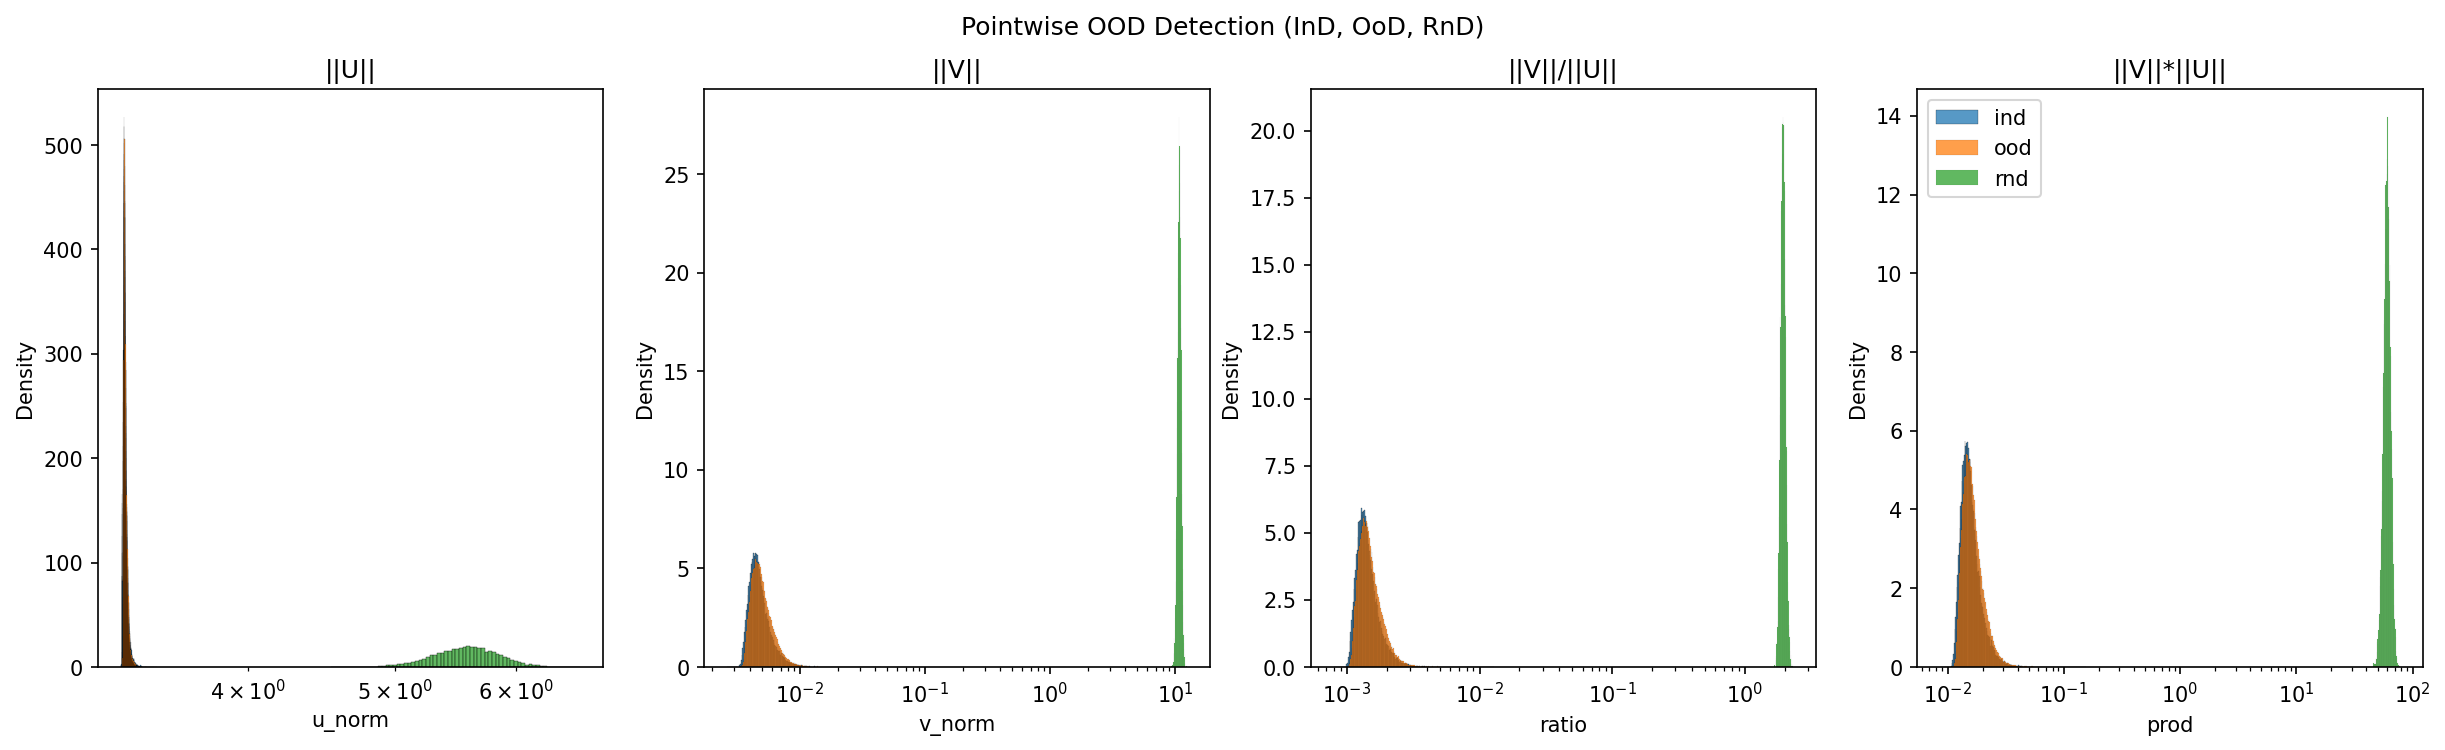

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (InD, OoD, RnD)")

sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
print(ks_ind_ood)

Ind 0.0026210467 0.044570167 0.04194912
Ood 0.0026210467 1.3524563 1.3498353
Rnd 9.380471 12.405969 3.0254974
KstestResult(statistic=0.10716923378523241, pvalue=1.4055239111849826e-281, statistic_location=0.0047226055, statistic_sign=1)


[0 1 3 2 4]


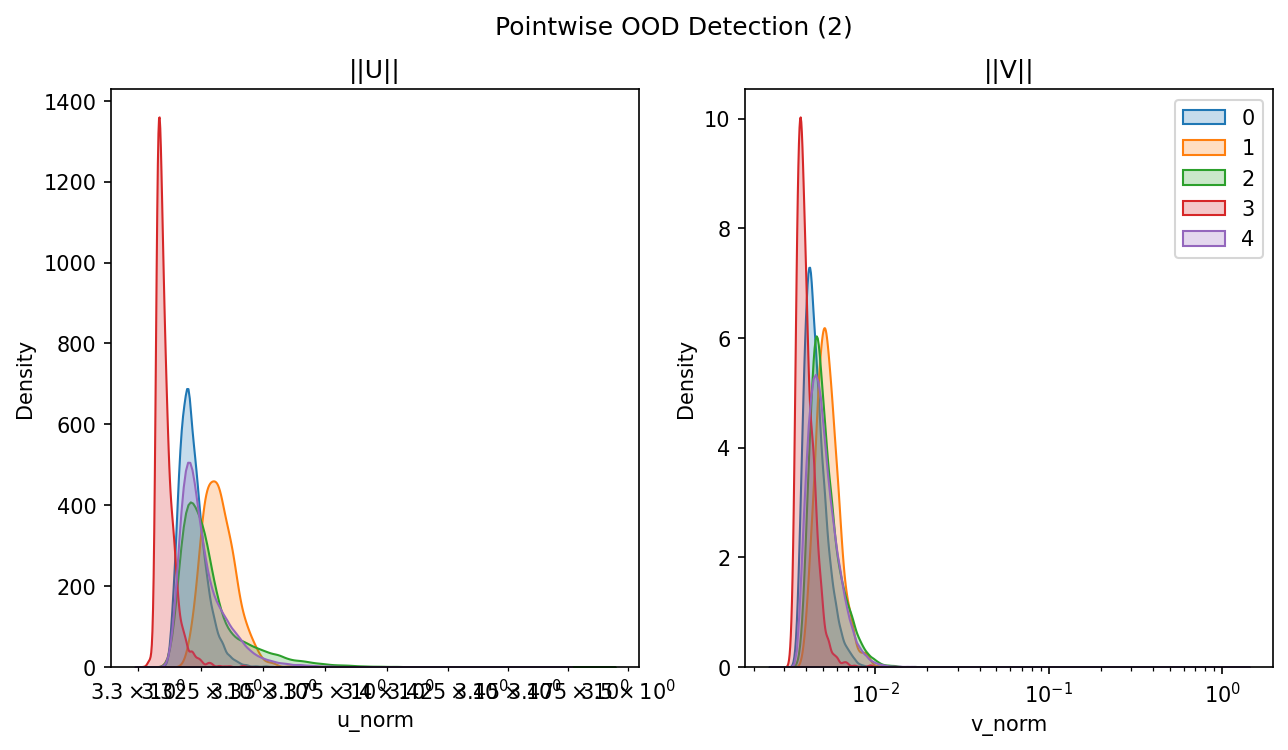

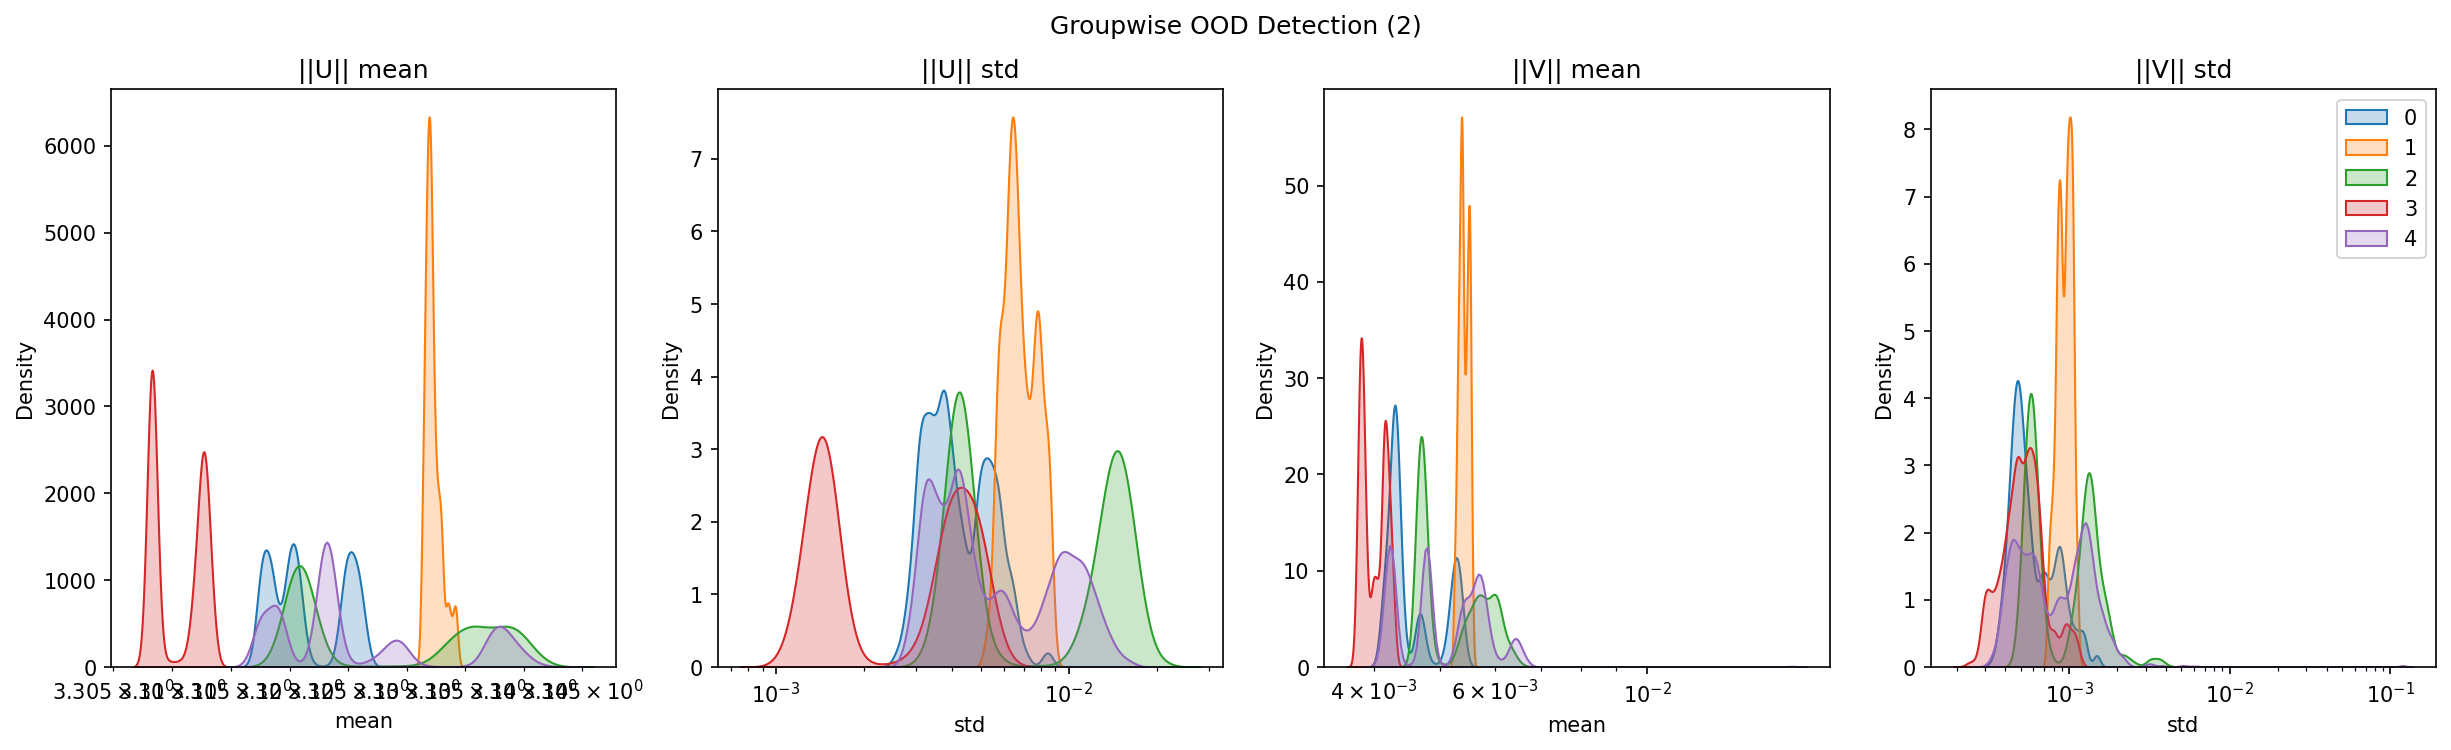

In [14]:
df = pd.concat([data_ind, data_ood], axis=0)
print(df['target'].unique())

N = 128

pointwise = {}
groupwise = {}

for i in range(5):
    df_slice = df[df['target'] == i]
    pointwise[i] = df_slice.copy()
    d = df_slice.rolling(N).agg(['mean', 'std']).dropna()
    groupwise[i] = d.copy()

# pointwise
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle(f"Pointwise OOD Detection ({':'.join(map(str,config.ood))})")

for i in range(5):
    data = pointwise[i]
    i = str(i)
    sns.kdeplot(data=data, x="u_norm", log_scale=True, fill=True, label=i, ax=ax1)
    sns.kdeplot(data=data, x="v_norm", log_scale=True, fill=True, label=i, ax=ax2)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
plt.legend()
plt.show()

    
# groupwise
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle(f"Groupwise OOD Detection ({':'.join(map(str,config.ood))})")

for i in range(5):
    data = groupwise[i]
    i = str(i)
    sns.kdeplot(data=data.u_norm, x="mean", log_scale=True, fill=True, label=i, ax=ax1)
    sns.kdeplot(data=data.u_norm, x="std", log_scale=True, fill=True, label=i, ax=ax2)
    sns.kdeplot(data=data.v_norm, x="mean", log_scale=True, fill=True, label=i, ax=ax3)
    sns.kdeplot(data=data.v_norm, x="std", log_scale=True, fill=True, label=i, ax=ax4)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()